## 0. Import library

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from sklearn.cluster import DBSCAN
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
import os
from concurrent.futures.process import ProcessPoolExecutor
from concurrent.futures import as_completed
from itertools import repeat
import pickle
import math
from tqdm import tqdm
import time
from mylib.user_func import detect_peaks, twoD_Gaussian, centroid, gauss, bayesian_inference, generate_cmap, analysis_pervskite
%matplotlib inline

## Load image and set parameters

In [34]:
# Parameter
model = "Gaussian"       # "CoM" or "Gaussian"
size_peak_search = 20    # pix size of ROI for peak search
size_peak = 20           # pix size of ROI for Gaussian (or CoM) fitting
threshold = 0.4         # Minimun threshold of peak intensity against maximun intensity of image
edge = 1.4               # region (edge * size_peak) where peak is ignored
n_iter = 6               # Number of loops for Gaussian fit
eps = 3                  # DBSCANのパラメータ
ratio = 20               # Magnification of arrows in displacement map
#calibration = 14.451       # pm/pix(ARM_1K)
#calibration = 7.208       # pm/pix(ARM_2K)
#calibration = 12.102       # pm/pix(spectra_1K)
calibration = 10       # pm/pix(spectra_2K)
display_sigma = 1        # グラフに表示する誤差の大きさ(1: 68%, 2: 95%, 3: 99.7%)
scan_distortion = 0    # スキャン影響による変位決定精度の誤差(1標準偏差) [pm]
input_file = "SrTiO3_20cell_simu_intensity50.dm4"
output_dir = "SrTiO3_50cell_simu_intensity100.dm4"
FWHM = size_peak/2       # Initial value of FWHM for Gaussian fitting

# Import an image
cur_dir = os.getcwd()    # Get filepath of current directory
if os.name == "nt":      # If os is Windows
    data_dir = os.path.dirname(cur_dir) + "\\data"
    ds = hs.load(data_dir + "\\" + input_file)
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data"
    ds = hs.load(data_dir + "//" + input_file)      
s = hs.signals.Signal1D(ds)
ydim, xdim, = s.data.shape
Z = np.flipud(s.data)    # Flip vertically because dm4 has inverse definition of y-axis against matplotlib

## Detect peaks roughly

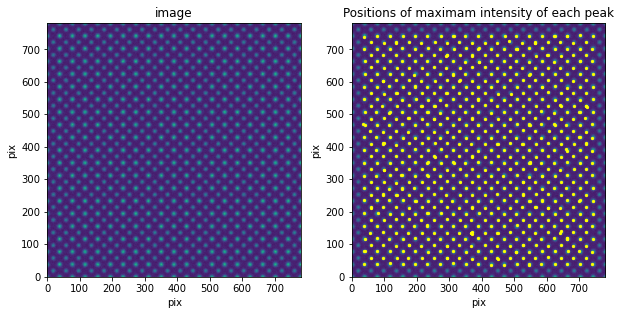

In [35]:
# Search peaks roughly
peaks_maximam = detect_peaks(Z, edge, filter_size=size_peak_search, order=threshold)

# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_maximam[1], peaks_maximam[0], s=5, c="yellow", marker="o")
ax2.set_title("Positions of maximam intensity of each peak")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
plt.show()

## Clustering Peaks

In [36]:
# Peak detection
min_samples = int((xdim/size_peak)/2*0.6)   # Lower threshold on cluster formation factors in DBSCAN clustering

# Clustering by DBSCAN
peaks_x = peaks_maximam[1]
peaks_y = peaks_maximam[0]
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(np.reshape(peaks_y, [-1, 1]))
labels = dbscan_model.labels_ + 1
col = max(labels)
inlier_peaks_x = peaks_x[~(labels == 0)]
inlier_peaks_y = peaks_y[~(labels == 0)]
cluster_centers = np.array([np.average(peaks_y[(labels == i)]) for i in range(col) ])
labels = labels[~(labels == 0)] - 1

print("Number of peaks = {0}".format(len(peaks_maximam[0])))
print("Number of rows = {0}".format(col))
print("Number of atoms in rows = {0}".format(int(len(labels)/col)))
print("Minimun limit in rows = {0}".format(min_samples*2))

Number of peaks = 782
Number of rows = 37
Number of atoms in rows = 21
Minimun limit in rows = 22


c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Peak fit using simple 2D Gaussian

In [37]:
# Fit 2D gaussian
fit_method = "simple"

decimal = 4    #原子位置の重複を判定する際に、小数点以下第何位までを考慮して判定するか(pix)。初めは0からスタートし、徐々に値を大きくしていくと良い。重複がなくなったら、3以上を入力して次へ

# Calculate atomic positions
peaks = set()
for h in tqdm(range(len(peaks_y))):
    px = peaks_x[h]
    py = peaks_y[h]
    for i in range(n_iter):
        if model == "CoM": cx,cy = centroid(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))])
        if model == "Gaussian": cx,cy = gauss(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))], size_peak, FWHM)
        px = round(round(px-size_peak/2)+cx, decimal)
        py = round(round(py-size_peak/2)+cy, decimal)
    #print("i = {0}".format(h))
    #print("px = {0}".format(px))
    #print("py = {0}".format(py))
    #print("cx = {0}".format(cx))
    #print("cy = {0}\n".format(cy))
    peaks.add((px, py))

peaks_x = [ x for x, y in peaks ]
peaks_y = [ y for x, y in peaks ]
print("Number of peaks = {0} ⇒ {1}".format(len(peaks_maximam[0]), len(peaks)))

100%|██████████| 782/782 [00:11<00:00, 65.35it/s]

Number of peaks = 782 ⇒ 687


## Check for double count

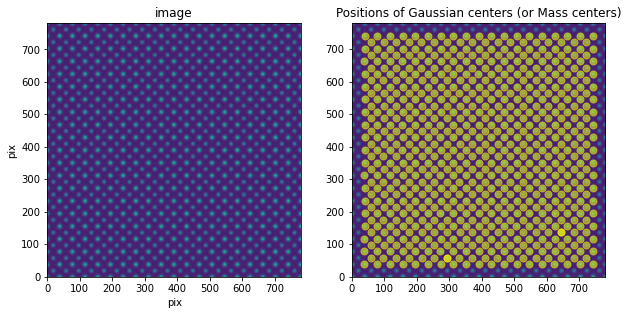

In [51]:
# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=50, c="yellow", marker="o", alpha=0.5)    #sの値を適宜調整して、見やすくすると良い
#for i in range(len(peaks_x)):
    #ax2.text(peaks_x[i], peaks_y[i], str(i), color="black", fontsize=12)
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
plt.show()

## Peak fit using 2D Gaussian with Bayesian inference

In [39]:
workers = 2    # workers < num_CPU_core/3
num_sample = 2000   # number of samples for Bayesian inference
chains = 2

# Parallel processing of bayesian inference
fit_method = "bayes"
patch = [ Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))] for i in range(len(peaks)) ]
summary_all = []

# Prepare arguments for bayesian_inference function
args = zip(repeat(size_peak), patch, repeat(num_sample), repeat(chains))

with ProcessPoolExecutor(max_workers=workers) as executor:
    futures = [ executor.submit(bayesian_inference, *arg) for arg in args ]     # Submit tasks to the executor
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):       # Iterate over completed futures with a progress bar
        summary_all.append(future.result())

#with ProcessPoolExecutor(max_workers=workers) as executor:
#    summary = executor.map(bayesian_inference, repeat(size_peak), patch, repeat(num_sample))
#for s in summary:
#    summary_all.append(s)

Processing: 100%|██████████| 687/687 [8:49:46<00:00, 46.27s/it]   


In [40]:
sd_x_bayes = np.zeros_like(peaks_x)
sd_y_bayes = np.zeros_like(peaks_y)
peaks_x_bayes = np.zeros_like(peaks_x)
peaks_y_bayes = np.zeros_like(peaks_y)
for i in range(len(peaks)):
    sd_x_bayes[i] = summary_all[i][0].loc["Atom Position (μ)[0]", "sd"]
    sd_y_bayes[i] = summary_all[i][0].loc["Atom Position (μ)[1]", "sd"]
    peaks_x_bayes[i] = round(round(peaks_x[i]-size_peak/2) + summary_all[i][0].loc["Atom Position (μ)[0]", "mean"], decimal)
    peaks_y_bayes[i] = round(round(peaks_y[i]-size_peak/2) + summary_all[i][0].loc["Atom Position (μ)[1]", "mean"], decimal)

In [41]:
# Confirmation of main results of bayesian inference
pd.options.display.precision = 3
summary_df = pd.DataFrame([], index=[i for i in range(len(peaks))], columns=["Mean-x [pix]", "Mean-y [pix]", "SD-x [pix]", "SD-y [pix]", "r_hat"])
for i in range(len(peaks)):
    summary_df.loc[i, "Mean-x [pix]"] = summary_all[i][0].loc["Atom Position (μ)[0]", "mean"]
    summary_df.loc[i, "Mean-y [pix]"] = summary_all[i][0].loc["Atom Position (μ)[1]", "mean"]
    summary_df.loc[i, "SD-x [pix]"] = summary_all[i][0].loc["Atom Position (μ)[0]", "sd"]
    summary_df.loc[i, "SD-y [pix]"] = summary_all[i][0].loc["Atom Position (μ)[1]", "sd"]
    summary_df.loc[i, "r_hat"] = summary_all[i][0].loc["Atom Position (μ)[0]", "r_hat"]
pd.set_option("display.max_rows", len(summary_df))

summary_df

,Mean-x [pix],Mean-y [pix],SD-x [pix],SD-y [pix],r_hat
0,9.676,9.526,0.105,0.106,1.0
1,10.146,10.0,0.082,0.08,1.0
2,9.638,10.215,0.107,0.105,1.0
3,10.169,9.925,0.081,0.079,1.0
4,9.72,10.318,0.102,0.112,1.0
5,10.126,9.793,0.086,0.089,1.0
6,9.933,9.893,0.077,0.076,1.0
7,10.231,9.551,0.098,0.103,1.0
8,10.494,10.2,0.11,0.106,1.0
9,10.123,9.93,0.093,0.086,1.0


In [42]:
# Calcurate possible peak positions (n=num_sample) from posterior distributiuon of Bayesian inference
pred_sampled_peaks_x = [ [] for _ in range(num_sample) ]
pred_sampled_peaks_y = [ [] for _ in range(num_sample) ]

for i in range(len(peaks)):
    for k in summary_all[i][1].values():
        for j in range(num_sample):
            pred_sampled_peaks_x[j].append(round(round(peaks_x[i]-size_peak/2) + k[j][0], decimal))
            pred_sampled_peaks_y[j].append(round(round(peaks_y[i]-size_peak/2) + k[j][1], decimal))

In [48]:
len(peaks_x)
len(peaks_y)

687

## Analysis for Pervskite crystal

In [52]:
if fit_method == "simple":
    sd_x_bayes = []
    sd_y_bayes = []

# Analysis for SrTiO3-like pervskite materials
distances, flat_distance_x, flat_distance_y, flat_align_peaks_x, flat_align_peaks_y, flat_sd_x, flat_sd_y, flat_align_sd_x, flat_align_sd_y, flat_center_x, flat_center_y = analysis_pervskite(Z, col, peaks_x, peaks_y, sd_x_bayes, sd_y_bayes, size_peak, fit_method)
#distances, flat_distance_x, flat_distance_y, flat_align_peaks_x, flat_align_peaks_y, flat_sd_x, flat_sd_y, flat_align_sd_x, flat_align_sd_y, flat_center_x, flat_center_y = analysis_pervskite(Z, col, peaks_x_bayes, peaks_y_bayes, sd_x_bayes, sd_y_bayes, size_peak, fit_method)

c:\Users\nomura\OneDrive - 一般財団法人ファインセラミックスセンター\ドキュメント\05_ソフトウェア\02_PeakDetection_Perovskite\src\mylib\user_func.py:243: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  distance_x = [ align_peaks_x[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算


TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [ ]:
# Calcurate possible Ti displacement from posterior distribution of Bayesian inference
pred_distances = [ [] for _ in range(num_sample) ]
pred_flat_distance_x = [ [] for _ in range(num_sample) ]
pred_flat_distance_y = [ [] for _ in range(num_sample) ]
pred_flat_align_peaks_x = [ [] for _ in range(num_sample) ]
pred_flat_align_peaks_y = [ [] for _ in range(num_sample) ]
pred_flat_sd_x = [ [] for _ in range(num_sample) ] 
pred_flat_sd_y = [ [] for _ in range(num_sample) ]
pred_flat_align_sd_x = [ [] for _ in range(num_sample) ]
pred_flat_align_sd_y = [ [] for _ in range(num_sample) ]
pred_flat_center_x = [ [] for _ in range(num_sample) ]
pred_flat_center_y = [ [] for _ in range(num_sample) ]

for i in tqdm(range(num_sample)):
    distances_dummy, flat_distance_x_dummy, flat_distance_y_dummy, flat_align_peaks_x_dummy, flat_align_peaks_y_dummy, flat_sd_x_dummy, flat_sd_y_dummy, flat_align_sd_x_dummy, flat_align_sd_y_dummy, flat_center_x_dummy, flat_center_y_dummy = analysis_pervskite(Z, col, pred_sampled_peaks_x[i], pred_sampled_peaks_y[i], sd_x_bayes, sd_y_bayes, size_peak, fit_method)
    pred_distances[i] = distances_dummy
    pred_flat_distance_x[i] = flat_distance_x_dummy
    pred_flat_distance_y[i] = flat_distance_y_dummy
    pred_flat_align_peaks_x[i] = flat_align_peaks_x_dummy
    pred_flat_align_peaks_y[i] = flat_align_peaks_y_dummy
    pred_flat_sd_x[i] = flat_sd_x_dummy
    pred_flat_sd_y[i] = flat_sd_y_dummy
    pred_flat_align_sd_x[i] = flat_align_sd_x_dummy
    pred_flat_align_sd_y[i] = flat_align_sd_y_dummy
    pred_flat_center_x[i] = flat_center_x_dummy
    pred_flat_center_y[i] = flat_center_y_dummy

100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


## Make Plots for conventional method

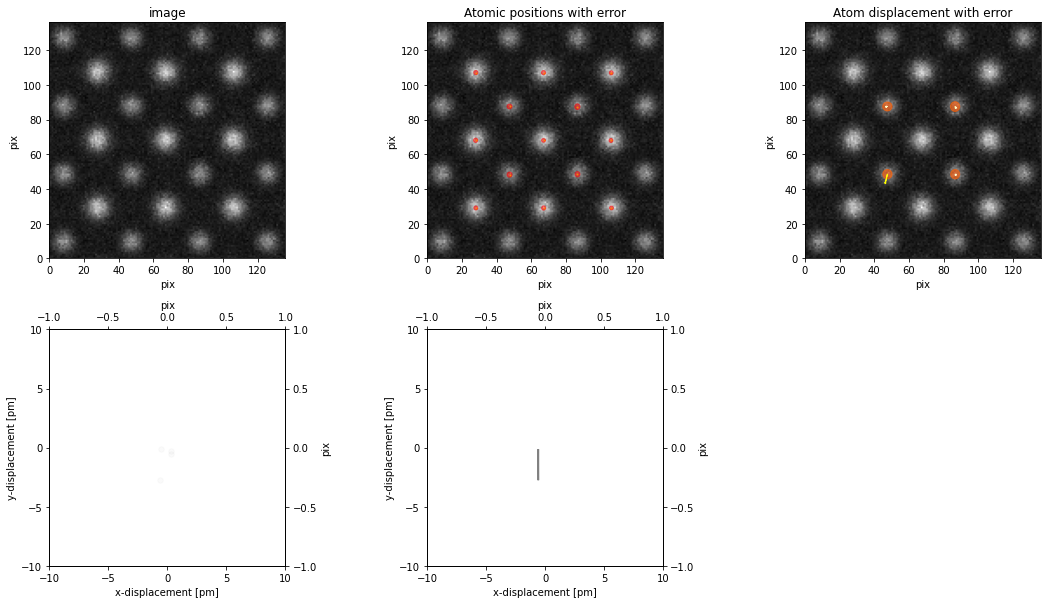

Mean of displacement [pm] = (-0.15, -0.94)
Standard deviation(x, y) of displacement [pm] = (0.47, 1.06)
Standard deviation(kobayashi) of displacement [pm] = (0.99)


In [31]:
# pred_flat_distanceをcalibration倍したリストを作成
multi_flat_distance_x = [ x*calibration for x in flat_distance_x ]
multi_flat_distance_y = [ y*calibration for y in flat_distance_y ]

# 矢印のカラーを定義
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances[i]/sorted(distances)[-1] for i in range(len(flat_distance_x))])
color = np.where(color>=1, 0.99, color)
color = cm(color)

# Create a GridSpec layout
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1], wspace=0.6, hspace=0.3)

# Make plots
fig = plt.figure(figsize=(17.77,10))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])

ax1.imshow(Z, origin="lower", cmap="gray")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)

ax2.imshow(Z, origin="lower", cmap="gray")
ax2.scatter(peaks_x, peaks_y, s=1, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
if fit_method == "bayes":
    for i in range(len(flat_align_peaks_x)):
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax2.add_patch(patches.Ellipse(xy=(flat_align_peaks_x[i], flat_align_peaks_y[i]), width= flat_align_sd_x[i]*ratio*2*display_sigma, height= flat_align_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
if fit_method == "simple": ax2.set_title("Positions of Gaussian centers")
elif fit_method == "bayes": ax2.set_title("Atomic positions with error")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)

ax3.imshow(Z, origin="lower", cmap="gray")
for i in range(len(flat_distance_x)):
#    ax3.annotate('', xy=[flat_center_x[i] + flat_distance_x[i]*ratio/2, flat_center_y[i]+flat_distance_y[i]*ratio/2], xytext=[flat_center_x[i]-flat_distance_x[i]*ratio/2, flat_center_y[i]-flat_distance_y[i]*ratio/2], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
#                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    ax3.annotate('', xy=[ flat_center_x[i] + flat_distance_x[i]*ratio, flat_center_y[i] + flat_distance_y[i]*ratio ], xytext=[flat_center_x[i], flat_center_y[i]], 
                arrowprops=dict(shrink=0, width=0.1, headwidth=1.5, headlength=1, connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    if fit_method == "bayes":
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width= flat_sd_x[i]*ratio*2*display_sigma, height= flat_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width=(flat_sd_x[i]+scan_distortion/calibration)*2*ratio*display_sigma, height=(flat_sd_y[i]+scan_distortion/calibration)*2*ratio*display_sigma, angle=0, color="yellow", alpha=0.2))
if fit_method == "simple": ax3.set_title("Atom displacement")
elif fit_method == "bayes": ax3.set_title("Atom displacement with error")
ax3.set_xlabel("pix")
ax3.set_ylabel("pix")
ax3.set_xlim(0, xdim)
ax3.set_ylim(0, ydim)

ax4.scatter(np.array(flat_distance_x)*calibration, np.array(flat_distance_y)*calibration, s=30, c="black", marker="o", alpha=0.02)
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
#ax4.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
#ax4.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_xlim(-10, 10)
ax4.set_ylim(-10, 10)
ax4_twinx = ax4.twinx()  # Create a new y-axis
ax4_twiny = ax4.twiny()  # Create a new x-axis
ax4_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax4_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax4_twiny.set_xlim(-1, 1)
ax4_twinx.set_ylim(-1, 1)

az.plot_kde(multi_flat_distance_x, values2=multi_flat_distance_y, ax=ax5, hdi_probs=[ 0.6827, 0.9545 ] )
ax5.set_xlabel("x-displacement [pm]")
ax5.set_ylabel("y-displacement [pm]")
ax5.set_xlim(-10, 10)
ax5.set_ylim(-10, 10)
ax5_twinx = ax5.twinx()  # Create a new y-axis
ax5_twiny = ax5.twiny()  # Create a new x-axis
ax5_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax5_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax5_twinx.set_ylim(-1, 1)
ax5_twiny.set_xlim(-1, 1)

# Set integer tick intervals for ax4 and ax5
for ax in [ax4, ax5]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax4_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax4_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax5_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax5_twiny.xaxis.set_major_locator(MultipleLocator(0.5))

plt.savefig(data_dir + "\\" + "01_summary_conventional.png", dpi=1200)
plt.show()

#変位の平均と標準偏差の表示
std_x = np.std(np.array(flat_distance_x))*calibration
std_y = np.std(np.array(flat_distance_y))*calibration
flat_distance = np.sqrt(np.array(flat_distance_x)**2 + np.array(flat_distance_y)**2)*calibration
kobayashi_std = np.std(flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(flat_distance_x))*calibration, np.mean(np.array(flat_distance_y))*calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(std_x, std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## Make plot possible Ti displacement from posterior distribution (for 1 unit cell)

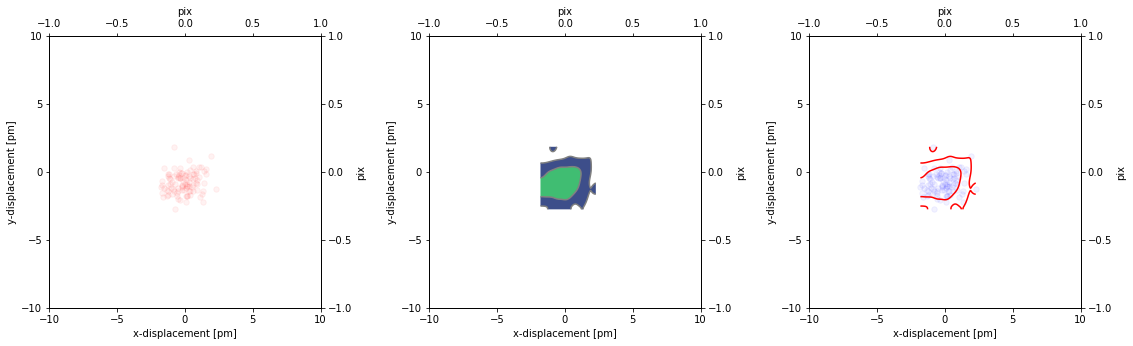

Mean of displacement [pm] = (-0.26, -1.12)
Standard deviation(x, y) of displacement [pm] = (0.78, 1.19)
Standard deviation(kobayashi) of displacement [pm] = (0.92)


In [32]:
k = 1   # number of Ti displacement for plot

# pred_flat_distanceをcalibration倍したリストを作成
multi_pred_flat_distance_x = [ x[k]*calibration for x in pred_flat_distance_x ]
multi_pred_flat_distance_y = [ y[k]*calibration for y in pred_flat_distance_y ]

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1], wspace=0.4)

# Make plots
fig = plt.figure(figsize=(18.48, 5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

for i in range(num_sample):
    ax1.scatter(np.array(pred_flat_distance_x[i][k]*calibration), np.array(pred_flat_distance_y[i][k])*calibration, s=30, c="red", marker="o", alpha=0.05)
ax1.set_xlabel("x-displacement [pm]")
ax1.set_ylabel("y-displacement [pm]")
#ax1.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
#ax1.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1_twinx = ax1.twinx()  # Create a new y-axis
ax1_twiny = ax1.twiny()  # Create a new x-axis
ax1_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax1_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax1_twiny.set_xlim(-1, 1)
ax1_twinx.set_ylim(-1, 1)

az.plot_kde(multi_pred_flat_distance_x, values2=multi_pred_flat_distance_y, ax=ax2, hdi_probs=[ 0.6827, 0.9545 ] )
ax2.set_xlabel("x-displacement [pm]")
ax2.set_ylabel("y-displacement [pm]")
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2_twinx = ax2.twinx()  # Create a new y-axis
ax2_twiny = ax2.twiny()  # Create a new x-axis
ax2_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax2_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax2_twiny.set_xlim(-1, 1)
ax2_twinx.set_ylim(-1, 1)

az.plot_kde(multi_pred_flat_distance_x, values2=multi_pred_flat_distance_y, ax=ax3, hdi_probs=[ 0.6827, 0.9545 ],
            contour_kwargs={ "colors": "red", "alpha": 1 }, contourf_kwargs={ "alpha": 0 } )
for i in range(num_sample):
    ax3.scatter(np.array(pred_flat_distance_x[i][k]*calibration), np.array(pred_flat_distance_y[i][k])*calibration, s=30, c="blue", marker="o", alpha=0.05)
ax3.set_xlabel("x-displacement [pm]")
ax3.set_ylabel("y-displacement [pm]")
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3_twinx = ax3.twinx()  # Create a new y-axis
ax3_twiny = ax3.twiny()  # Create a new x-axis
ax3_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax3_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax3_twiny.set_xlim(-1, 1)
ax3_twinx.set_ylim(-1, 1)

# Set integer tick intervals for ax4 and ax5
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax1_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax1_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax2_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax2_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax3_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax3_twiny.xaxis.set_major_locator(MultipleLocator(0.5))

plt.savefig(data_dir + "\\" + "02_summary_bayese.png", dpi=1200)
plt.show()

#変位の平均と標準偏差の表示
pred_std_x = np.std(np.array(pred_flat_distance_x))*calibration
pred_std_y = np.std(np.array(pred_flat_distance_y))*calibration
pred_flat_distance = np.sqrt(np.array(pred_flat_distance_x)**2 + np.array(pred_flat_distance_y)**2)*calibration
pred_kobayashi_std = np.std(pred_flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(pred_flat_distance_x))*calibration, np.mean(np.array(pred_flat_distance_y))*calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(pred_std_x, pred_std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(pred_kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

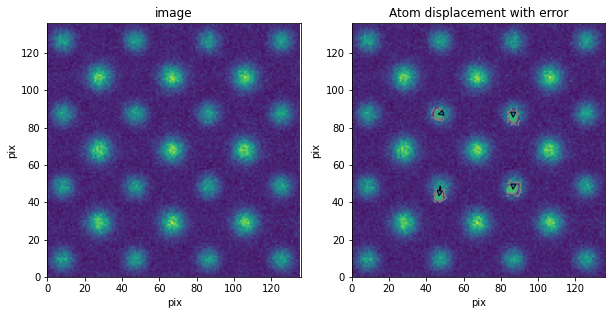

In [33]:
# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)

ax2.imshow(Z, origin="lower")
for i in range(len(pred_flat_distance_x[0])):
    az.plot_kde(np.average(np.array(pred_flat_center_x), axis=0)[i] + np.array(pred_flat_distance_x).T[i]*ratio, 
                values2=np.average(np.array(pred_flat_center_y), axis=0)[i] + np.array(pred_flat_distance_y).T[i]*ratio, 
                ax=ax2, hdi_probs=[ 0.6827, 0.9545 ] )
for i in range(len(pred_flat_distance_x[0])):
    ax2.annotate('', 
                xy = [ np.average(np.array(pred_flat_center_x), axis=0)[i] + np.average(np.array(pred_flat_distance_x), axis=0)[i]*ratio, np.average(np.array(pred_flat_center_y), axis=0)[i] + np.average(np.array(pred_flat_distance_y), axis=0)[i]*ratio ], 
                xytext = [ np.average(np.array(pred_flat_center_x), axis=0)[i] , np.average(np.array(pred_flat_center_y), axis=0)[i] ], 
                arrowprops=dict(shrink=0, width=1, headwidth=5, headlength=5, connectionstyle='arc3'))    #"xy"が終点、"xytext"が始点
ax2.set_title("Atom displacement with error")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)

plt.show()

## 9. Save/Load results of Bayesian inference

In [25]:
# save results of Bayesian inference
if os.name == "nt":      # If OS is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir 
    os.mkdir(out_dir)
    out_dir += "\\"
if os.name == "posix":   # If OS is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir
    os.mkdir(out_dir)
    out_dir += "//"

# save files
with open(out_dir + 'summary_all.pkl', 'wb') as f:
    pickle.dump(summary_all, f)
np.save(out_dir + "STEM_image.npy", Z)
np.save(out_dir + "Bayes_peaks-x.npy", peaks_x)
np.save(out_dir + "Bayes_peaks-y.npy", peaks_y)
np.save(out_dir + "Bayes_sd-x.npy", sd_x_bayes)
np.save(out_dir + "Bayes_sd-y.npy", sd_y_bayes)

In [ ]:
# 「Peak fit using simple 2D Gaussian」まで実行 ⇒ このセルを実行 ⇒ 

# load results of Bayesian inference
fit_method = "bayes"
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir + "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir + "//"

# load files
with open(out_dir + 'summary_all.pkl', 'rb') as f:
    summary_all = pickle.load(f)
Z = np.load(out_dir + 'STEM_image.npy')
peaks_x = np.load(out_dir + 'Bayes_peaks-x.npy')
peaks_y = np.load(out_dir + 'Bayes_peaks-y.npy')
sd_x_bayes = np.load(out_dir + 'Bayes_sd-x.npy')
sd_y_bayes = np.load(out_dir + 'Bayes_sd-y.npy')

summary_all

## 10. Test for example atom

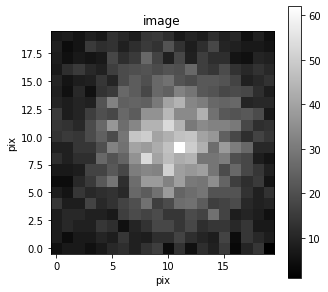

In [288]:
# Extract one atom
i = 1

# Make plots
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
im = ax1.imshow(Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))], origin="lower", cmap="gray")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
#ax1.set_xlim(0, size_peak)
#ax1.set_ylim(0, size_peak)
plt.colorbar(im)
plt.savefig(data_dir + "\\" + "03_1atom.png", dpi=1200)
plt.show()

In [289]:
# Bayesian inference of atomic position

# Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)

print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
#patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())

#MCMC Sampling
with model:
    trace = pm.sample(
        draws=1100,
        tune=1000,
        chains=3,
        return_inferencedata=True
    )

Bayesian Inference of atomic position: 2/4705


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 116 seconds.
INFO:pymc3:Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 116 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Atom Position (μ)[0],10.348,0.083,10.186,10.492,0.001,0.001,4325.0,2417.0,1.0
Atom Position (μ)[1],9.540,0.082,9.390,9.691,0.001,0.001,3491.0,2433.0,1.0
...,...,...,...,...,...,...,...,...,...
"Covariance Matrix[1, 0]",-0.572,0.517,-1.558,0.380,0.009,0.008,3647.0,2338.0,1.0
"Covariance Matrix[1, 1]",17.734,1.085,15.707,19.738,0.026,0.018,1796.0,2395.0,1.0


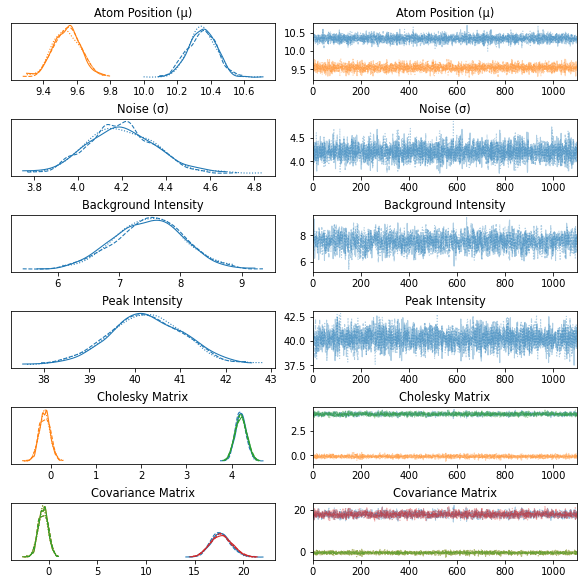

In [290]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(8,8))
plt.savefig(data_dir + "\\" + "04_trace_plot.png", dpi=1200)
az.summary(trace)

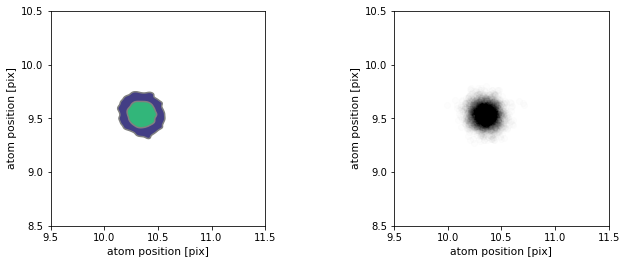

In [310]:
x_min, x_max, x_interval = 9.5, 11.5, 0.5
y_min, y_max, y_interval = 8.5, 10.5, 0.5

scatter_kwargs = { "c":"black", "marker":"o", "alpha":0.006 }
kde_kwargs = { "contour":True, "hdi_probs": [ 0.6827, 0.9545 ] }

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.6)

# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

az.plot_pair(trace, var_names=["Atom Position (μ)"], kind="kde", marginals=False, ax=ax1, textsize=10, kde_kwargs=kde_kwargs);
ax1.set_xticks(np.arange(x_min, x_max + x_interval, x_interval))
ax1.set_yticks(np.arange(y_min, y_max + y_interval, y_interval))
ax1.set_xlabel("atom position [pix]")
ax1.set_ylabel("atom position [pix]")
ax1.set_aspect('equal', adjustable='box')

az.plot_pair(trace, var_names=["Atom Position (μ)"], kind="scatter", marginals=False, ax=ax2, textsize=10, scatter_kwargs=scatter_kwargs);
ax2.set_xticks(np.arange(x_min, x_max + x_interval, x_interval))
ax2.set_yticks(np.arange(y_min, y_max + y_interval, y_interval))
ax2.set_xlabel("atom position [pix]")
ax2.set_ylabel("atom position [pix]")
ax2.set_aspect('equal', adjustable='box')

plt.savefig(data_dir + "\\" + "05_scatter_posterior_dist.png", dpi=1200)

In [ ]:
#Display credible interval
az.plot_posterior(trace, hdi_prob=0.9, backend_kwargs={"constrained_layout":True}, figsize=(10,10), textsize=10);

In [279]:
len(flat_distance_x)

2304